<a href="https://colab.research.google.com/github/mittyone/JSCCR-fStageII/blob/main/Machine_learning%2C_high_risk_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-survival

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
# data loading
data = pd.read_excel('JSCCR fStageII.xlsx')
data.head()

,gender,age,Approach,operation,Dissection Level,Pathology,pDepth,ly,v,CEA,LN number,DFS,Event,Location,Obstruction
0,1,1,1,5,3,1,1,1,1,1,2,5.000000,1,2,99
1,2,2,2,2,1,1,1,1,1,1,2,5.000000,1,1,1
2,2,1,2,5,2,1,2,1,1,2,1,3.978097,1,2,2
3,2,2,2,3,1,1,1,1,1,1,1,0.610541,2,1,2
4,2,2,2,4,3,1,2,1,2,1,2,5.000000,1,2,1


In [ ]:
# data preparation
target = np.array([(e == 2, t) for e, t in zip(data['Event'], data['DFS'])], dtype=[('Event', '?'), ('DFS', '<f8')])
features = data[['Pathology','pDepth', 'v','ly', 'CEA', 'LN number']]


In [ ]:
# data splitting

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [ ]:
# setting hyperparameters
param_distributions = {
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None] + list(range(10, 31, 10)),
    'min_samples_leaf': randint(1, 5),
    'n_estimators': randint(100, 301),
    'min_samples_split': randint(2, 11),
      'bootstrap': [True, False]
}


In [ ]:
# model training
rsf = RandomSurvivalForest(random_state=42)
random_search = RandomizedSearchCV(rsf, param_distributions=param_distributions, n_iter=100, random_state=42)
random_search.fit(X_train, y_train)


RandomizedSearchCV(estimator=RandomSurvivalForest(random_state=42), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0c318d7ca0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0c31780df0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0c318d5330>},
                   random_state=42)

In [ ]:
# obtaining optimal parameters
best_params = random_search.best_params_
best_rsf = RandomSurvivalForest(random_state=42, **best_params)
best_rsf.fit(X_train, y_train)


RandomSurvivalForest(max_depth=30, max_features='log2', min_samples_leaf=4,
                     n_estimators=136, random_state=42)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
# combining training and validation datasets
X_train_val = pd.concat([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

# retraining the model
rsf = RandomSurvivalForest(random_state=42, **best_params)
rsf.fit(X_train_val, y_train_val)

RandomSurvivalForest(max_depth=30, max_features='log2', min_samples_leaf=4,
                     n_estimators=136, random_state=42)

In [ ]:
# calculating feature importance (using training dataset))
random_state = 42  # random_state definition
result = permutation_importance(rsf, X_train_val, y_train_val, n_repeats=15, random_state=random_state)


In [ ]:
# evaluation with test data
prediction = best_rsf.predict(X_test)
c_index = concordance_index_censored(y_test['Event'], y_test['DFS'], prediction)
print("Best Parameters:", best_params)
print("Concordance Index on Test Set:", c_index[0])


Best Parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 136}
Concordance Index on Test Set: 0.517259056732741


In [ ]:
# creating data frame of results
feature_importances_df = pd.DataFrame(
    {
        "importances_mean": result['importances_mean'],
        "importances_std": result['importances_std']
    },
    index=X_train_val.columns
).sort_values(by="importances_mean", ascending=False)

print(feature_importances_df)


           importances_mean  importances_std
LN number          0.071066         0.010392
pDepth             0.064953         0.012294
v                  0.063758         0.011709
Pathology          0.062910         0.010393
CEA                0.059777         0.010688
ly                 0.048194         0.008293


In [ ]:
feature_importances_df.to_excel('pathological RSF feature importance.xlsx')

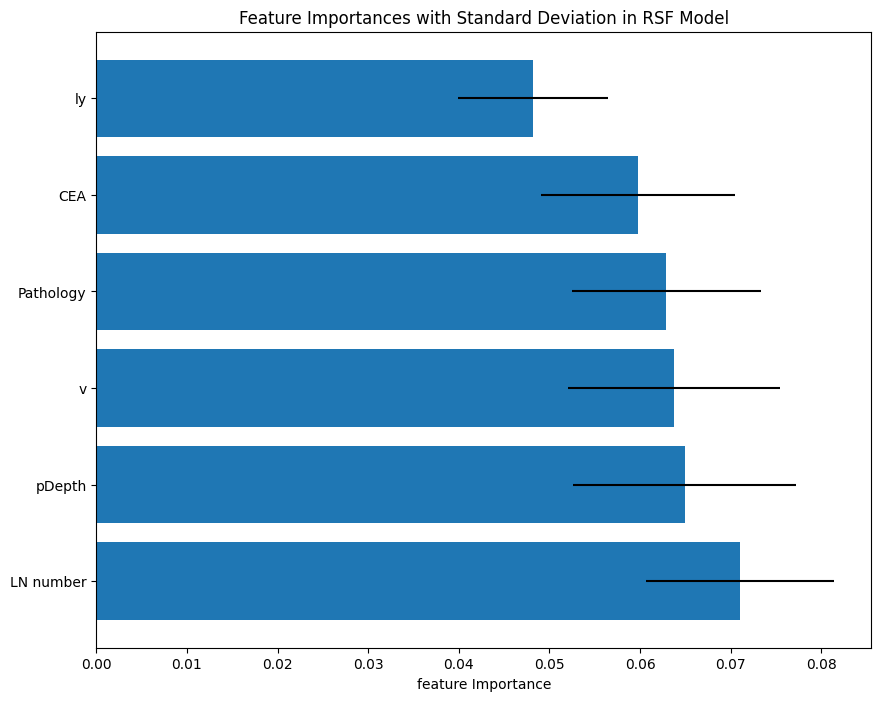

In [ ]:
# plotting feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# creating bar graphs with standard deviation as error bars
plt.barh(feature_importances_df.index, feature_importances_df['importances_mean'],
         xerr=feature_importances_df['importances_std'], align='center')

plt.xlabel('feature Importance')
plt.title('Feature Importances with Standard Deviation in RSF Model')
plt.show()



In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import GridSearchCV
from sksurv.metrics import concordance_index_censored

In [ ]:
# Data preparation (inherited from the original code)
X_train_val = pd.concat([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

# Setting the parameter range for grid search
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Creating an instance of the Cox model and setting up GridSearchCV
gscv = GridSearchCV(CoxPHSurvivalAnalysis(), param_grid, cv=5, scoring='roc_auc')

# Executing the grid search
gscv.fit(X_train_val, y_train_val)

# Displaying the optimal parameter
print("Best alpha:", gscv.best_params_['alpha'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. 

Best alpha: 0.01


In [ ]:
# Retraining the model with the optimal alpha
optimal_cox_model = CoxPHSurvivalAnalysis(alpha=gscv.best_params_['alpha'])
optimal_cox_model.fit(X_train_val, y_train_val)

# Making predictions on the test dataset
prediction = optimal_cox_model.predict(X_test)

# Calculating the Concordance Index
c_index = concordance_index_censored(y_test['Event'], y_test['DFS'], prediction)
print("Concordance Index on Test Set:", c_index[0])

Concordance Index on Test Set: 0.5607606679035251


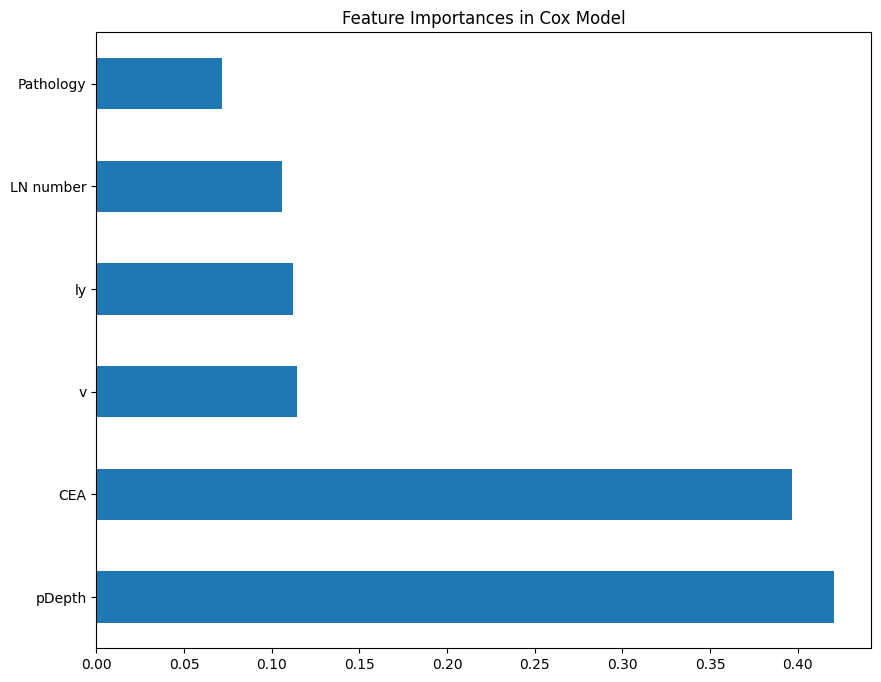

In [ ]:
# Retrieving the coefficients of the Cox model
cox_coef = optimal_cox_model.coef_

# Calculating the importance of features (based on the absolute value of coefficients)
feature_importances = pd.DataFrame(
    {"importances": np.abs(cox_coef)},
    index=X_train_val.columns
).sort_values(by="importances", ascending=False)

# Displaying the feature importances in a bar chart
plt.figure(figsize=(10, 8))
plt.xlabel('feature Importance')
feature_importances['importances'].plot(kind='barh')
plt.title('Feature Importances in Cox Model')
plt.show()

In [ ]:
feature_importances.to_excel('pathological Cox feature importance.xlsx')

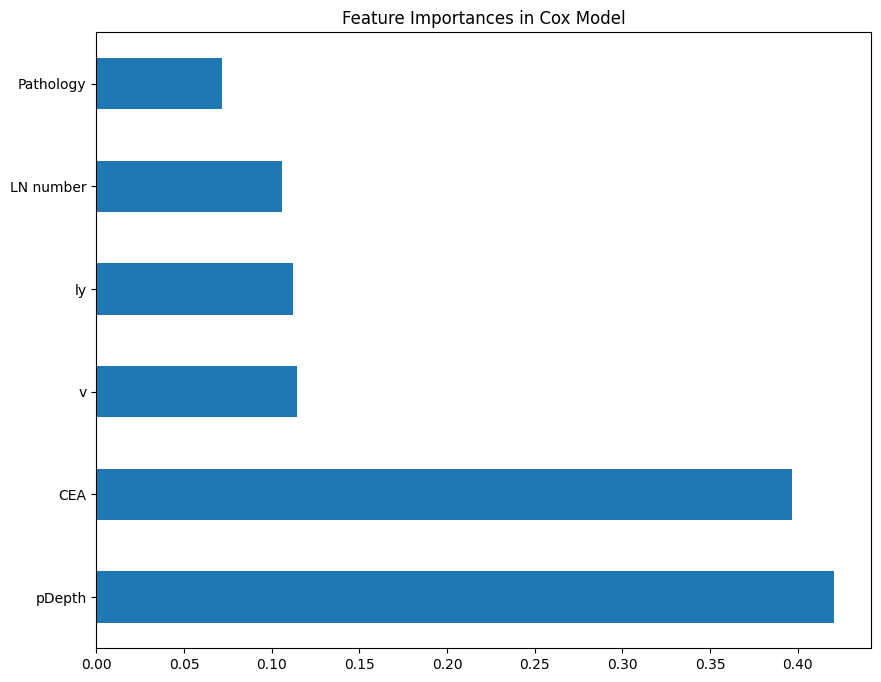

In [ ]:
import matplotlib.pyplot as plt

# creation of bar graph
plt.figure(figsize=(10, 8))
feature_importances['importances'].plot(kind='barh')
plt.title('Feature Importances in Cox Model')
plt.show()


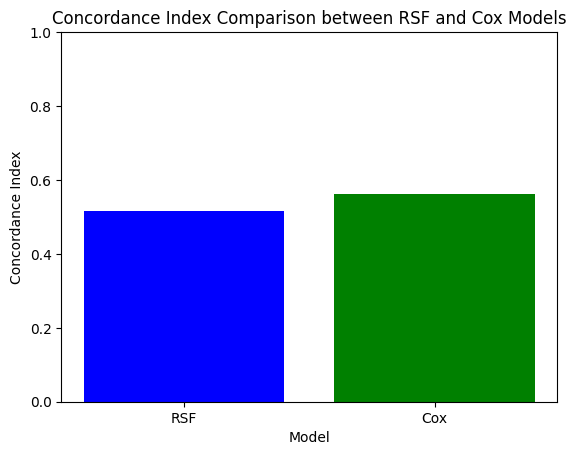

In [ ]:
import matplotlib.pyplot as plt

# calculation of concordance index for RSF model
rsf_prediction = best_rsf.predict(X_test)
rsf_c_index = concordance_index_censored(y_test['Event'], y_test['DFS'], rsf_prediction)[0]

# calculation of concordance index for COX model
prediction = optimal_cox_model.predict(X_test)
cox_c_index = concordance_index_censored(y_test['Event'], y_test['DFS'], prediction)[0]

# comparison of Concordance Index
models = ['RSF', 'Cox']
c_indexes = [rsf_c_index, cox_c_index]

# creation of bar chat
plt.bar(models, c_indexes, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Concordance Index')
plt.title('Concordance Index Comparison between RSF and Cox Models')
plt.ylim(0, 1)
plt.show()


In [ ]:
from sksurv.metrics import integrated_brier_score

# Define a time range for calculating the Brier Score
times = np.percentile(y_test['DFS'][y_test['Event']], np.linspace(5, 95, 10))

# Calculate the survival function for each sample in the test set
rsf_survival_functions = best_rsf.predict_survival_function(X_test)

# Format the survival functions for the integrated_brier_score
# Ensure the dimensions match: (number of samples, number of time points)
rsf_surv_funcs_formatted = np.array([fn(times) for fn in rsf_survival_functions])

# Confirm dimensions
print("Dimensions of y_test:", y_test.shape)
print("Dimensions of rsf_surv_funcs_formatted:", rsf_surv_funcs_formatted.shape)

# If dimensions match, calculate the integrated Brier score
if rsf_surv_funcs_formatted.shape[0] == len(y_test):
    rsf_brier_score = integrated_brier_score(y_test, y_test, rsf_surv_funcs_formatted, times)
    print("RSF Brier Score:", rsf_brier_score)
else:
    print("Dimension mismatch error")




Dimensions of y_test: (396,)
Dimensions of rsf_surv_funcs_formatted: (396, 10)
RSF Brier Score: 0.09148460795292497


In [ ]:
# Transform risk scores to survival functions
# This requires the baseline survival function from the Cox model
baseline_survival = optimal_cox_model.baseline_survival_
cox_risk_scores = optimal_cox_model.predict(X_test)
cox_survival_functions = np.exp(-np.outer(cox_risk_scores, baseline_survival(times)))

# Calculate the integrated Brier score
cox_brier_score = integrated_brier_score(y_test, y_test, cox_survival_functions, times)
print("Cox Brier Score:", cox_brier_score)


Cox Brier Score: 0.39036409153234386


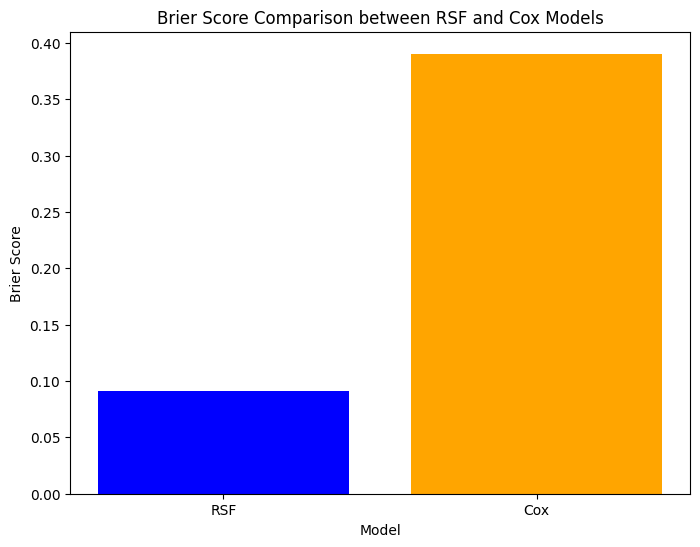

In [ ]:
# Brier Scores for each model
brier_scores = [rsf_brier_score, cox_brier_score]
models = ['RSF', 'Cox']

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, brier_scores, color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Brier Score')
plt.title('Brier Score Comparison between RSF and Cox Models')
plt.show()


In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

# Obtain predicted survival functions for the test dataset
rsf_survival_functions = best_rsf.predict_survival_function(X_test)
cox_survival_functions = optimal_cox_model.predict_survival_function(X_test)

# Set the time range used for calculating integrated AUC (using values from the 5th to the 95th percentile of survival times as an example)
times_auc = np.percentile(y_test['DFS'][y_test['Event']], np.linspace(5, 95, 19))

# Calculate integrated AUC for the RSF model
rsf_auc_scores = cumulative_dynamic_auc(y_train, y_test, [fn(times_auc) for fn in rsf_survival_functions], times_auc)

# Calculate integrated AUC for the Cox model
cox_risk_scores = optimal_cox_model.predict(X_test)
cox_auc_scores = cumulative_dynamic_auc(y_train, y_test, np.exp(-np.outer(cox_risk_scores, times_auc)), times_auc)

# Display the results of integrated AUC
print("RSF Integrated AUC:", rsf_auc_scores[0][-1])  # Display the AUC at the last time point
print("Cox Integrated AUC:", cox_auc_scores[0][-1])  # Display the AUC at the last time point


RSF Integrated AUC: 0.5157990785130826
Cox Integrated AUC: 0.4361056750657903
